In [ ]:
! pip install serial -q
! pip install catboost -q
# !pip install hyperopt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.graphics.tsaplots as sgt
import scipy.stats as stats

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_validate

from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

%matplotlib inline
sns.set_context("talk")

# random state
RS = 1
# %matplotlib widget

In [ ]:
#В колабе импортируем все необходимые библиотеки
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1NawWHBHXznAtBE_t-XRxM4p986eYmrZU"})
# https://drive.google.com/file/d/1NawWHBHXznAtBE_t-XRxM4p986eYmrZU/view?usp=drive_link
download.GetContentFile("2023-05-31_17-14-41.palm")

download = drive.CreateFile({"id": "1g1pd5vZfFKYEXoX47FQ0XWjnh3IRIBPQ"})
# https://drive.google.com/file/d/1g1pd5vZfFKYEXoX47FQ0XWjnh3IRIBPQ/view?usp=sharing
download.GetContentFile("2023-05-31_17-14-41.palm.protocol.csv")

download = drive.CreateFile({"id": "1sVN7vFqUow4hQkt0Ef0GKGA4EhxlOQJZ"})
# https://drive.google.com/file/d/1sVN7vFqUow4hQkt0Ef0GKGA4EhxlOQJZ/view?usp=drive_link
download.GetContentFile("meta_information.csv")

download = drive.CreateFile({"id": "1i27QLfHXESzeFf1yz7RLkReq0meTfv8x"})
# https://drive.google.com/file/d/1i27QLfHXESzeFf1yz7RLkReq0meTfv8x/view?usp=sharing
download.GetContentFile("2023-05-31_15-46-37.palm.protocol.csv")

download = drive.CreateFile({"id": "1r4wVpeHrHYMdAV00hU_DrETAYDJZukhv"})
# https://drive.google.com/file/d/1r4wVpeHrHYMdAV00hU_DrETAYDJZukhv/view?usp=sharing
download.GetContentFile("2023-05-31_15-46-37.palm")

In [ ]:
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# IO utils


In [ ]:
def read_omg_csv(path_palm_data: str,
                 n_omg_channels: int,
                 n_acc_channels: int = 0,
                 n_gyr_channels: int = 0,
                 n_mag_channels: int = 0,
                 n_enc_channels: int = 0,
                 button_ch: bool = True,
                 sync_ch: bool = True,
                 timestamp_ch: bool = True) -> pd.DataFrame:

    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''

    df_raw = pd.read_csv(path_palm_data, sep=' ',
                         header=None,
                         skipfooter=1,
                         skiprows=1,
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()

    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'],
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]

    if button_ch:
        columns = columns + ['BUTTON']

    if sync_ch:
        columns = columns + ['SYNC']

    if timestamp_ch:
        columns = columns + ['ts']

    df_raw.columns = columns

    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [ ]:
# palm_file = '/home/user/Рабочий стол/Моторика/motorika-internship-team/data/2023-05-31_15-46-37.palm'
palm_file = './2023-05-31_15-46-37.palm'
gestures = read_omg_csv(palm_file,
                              n_omg_channels=50,
                              n_acc_channels=3,
                              n_gyr_channels=3,
                              n_enc_channels=6,
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19566, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,9,6,8,8,8,0,10,8,11,8,...,0,0,0,0,0,0,0,0,0,57807
1,6,6,6,6,8,0,8,7,8,8,...,-1,0,0,0,0,0,0,0,0,57840
2,10,4,7,6,6,2,7,10,11,9,...,0,0,0,0,0,0,0,0,0,57873
3,10,8,5,10,6,4,6,8,10,11,...,-1,0,0,0,0,0,0,0,0,57906
4,9,8,8,17,8,0,6,8,11,7,...,-2,0,0,0,0,0,0,0,0,57939


In [ ]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [ ]:
gestures.shape[-1]

65

In [ ]:
gestures.shape

(19566, 65)

In [ ]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

#gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH]

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### Protocol

In [ ]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [ ]:
gestures_protocol['Pronation'].value_counts()

0.0    61
0.5    60
1.0    60
Name: Pronation, dtype: int64

In [ ]:
gestures_protocol.shape

(181, 11)

In [ ]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [ ]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [ ]:
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int64

In [ ]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

## Определение временной задержки целевой переменной.

### Визуализация имеющегося сдвига

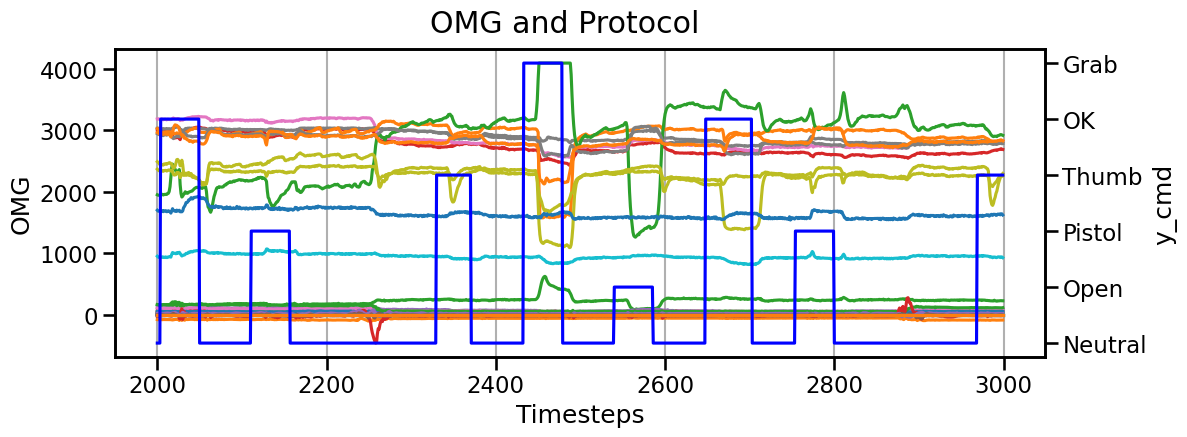

In [ ]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH][2000:3000])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df[2000:3000], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [ ]:
def add_feature_derivative(df):
  """Функция для добавления признака производной

    Args:
        df (DataFrame): датасет

    Returns:
        df_log(DataFrame): датасет с добавленным признаком производной
  """
  col_list_base = list(df.columns) #исходный список признаков
  df_temp = df.copy()
  for i in col_list_base:
    col_add = f'der_{i}' #название для нового признака
    df_temp[col_add] = df_temp[i].diff() #создаем признак
    df_temp.fillna(0, inplace = True) #удаляем пустоты
  df_temp.drop(col_list_base, axis = 1 , inplace = True)
  return df_temp

def get_clean_lines(df, treshold = 1.5):
  """Функция для преобразования временного ряда.
  Преобразует все значения выше определенного порога в 1, ниже в 0

    Args:
        df (Series): датасет

    Returns:
        result(DataFrame): преобразованный датасет
  """
  result = np.zeros(df.shape) #создаем массив заполненный нулями размером с датасет
  means = np.mean(df) #выводим среднюю
  for i in range(df.shape[0]): #перебираем значения
    if abs(df[i]) > means*treshold:  #реализуем логику
      result[i] = 1
    else:
      result[i] = 0
  return pd.DataFrame(result)

def shift_definition(df, target):
  """Функция для нахождения временной задержки между командой и её исполнением

    Args:
        df (DataFrame): датасет с показаниями датчиков
        target (DataFrame): данные протокола выполнения команд
    Returns:
        best_shift (int): временной сдвиг
  """
  # рассчитываем производные значений временных датчиков
  gestures_der = add_feature_derivative(df)
  # суммируем модули значений производных
  gestures_der_sum = abs(gestures_der).sum(axis = 1)
  # обнуляем значения ниже порога
  gestures_der_sum_clean = get_clean_lines(gestures_der_sum, treshold = 1.5)

  # преобразуем целевую переменную в DataFrame
  target_df = pd.DataFrame(target)
  # рассчитываем производные значений таргета
  target_der = add_feature_derivative(target_df)
  # преобразуем таргет, если есть жест 1, если нет 0
  for i in range(len(target_der)):
      if (target_der.iloc[i] != 0).bool():
        target_der.iloc[i] = 1

  # объединяем преобразованный таргет и преобрразованную сумму производных в одну таблицу
  data = pd.concat([gestures_der_sum_clean.shift(1), target_der], axis=1).dropna()
  data.columns = ['y_t', 'first_derivative']
  # определяем, при каком сдвиге корреляция  максимальна
  corr_temp = []
  for i in range(1, 40):
    data['y_t'] = data['y_t'].shift(i)
    corr_coef = data.corr()
    corr_temp.append(corr_coef.iloc[1,0])
  l = pd.Series(corr_temp)
  best_shift = l[l == max(corr_temp)]
  return best_shift.index[0]

In [ ]:
best_shift = shift_definition(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH], y_cmd)
print(best_shift)

23


### Визуализация соответствия команд и показаний от датчиков после сдвига целевой переменной

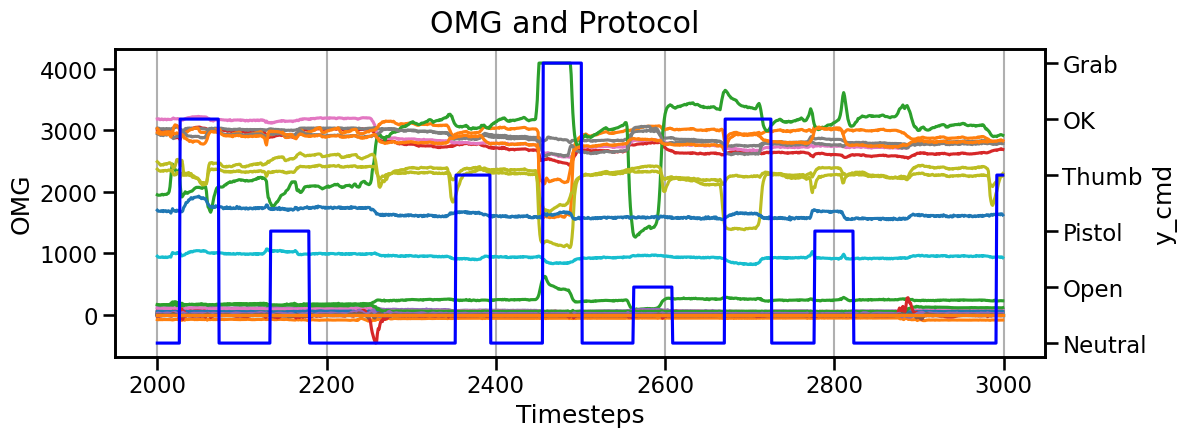

In [ ]:
fig, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
plt.suptitle('OMG and Protocol')
ax1.plot(gestures[OMG_CH + ACC_CH + GYR_CH + ENC_CH][2000:3000])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('OMG')
plt.grid(axis='x')
ax2 = ax1.twinx()
target_df = pd.DataFrame(y_cmd)
ax2.plot(target_df.shift(best_shift)[2000:3000], 'b-')
ax2.set_ylabel('y_cmd')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.show()

In [ ]:
# сдвигаем значения таргета
target_df = target_df.shift(best_shift).fillna(0)
y_cmd_shift = target_df.to_numpy()
y_cmd_shift

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

## Определение максимального количества лагов

In [ ]:
def plot_acf_pacf(series, lags, alpha=0.05):
    """Функция для построения графиков автокорреляции и частичной корреляции(коррелограм)

    Args:
        series (DataFrame, array): стационарный временной ряд
        lags (_type_): количество предыдущих наблюдений для поиска схожести/зависимости
        alpha (float, optional): Доверительный интервал. Defaults to 0.05.
    """

    plt.rcParams["figure.figsize"] = 18, 5 #размеры графика
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0], lags=lags, alpha=alpha)#построение графика автокорреляции
    sgt.plot_pacf(series, ax=axes[1], lags=lags, method="ywm", alpha=alpha)#построение графика автокорреляции
    plt.show()

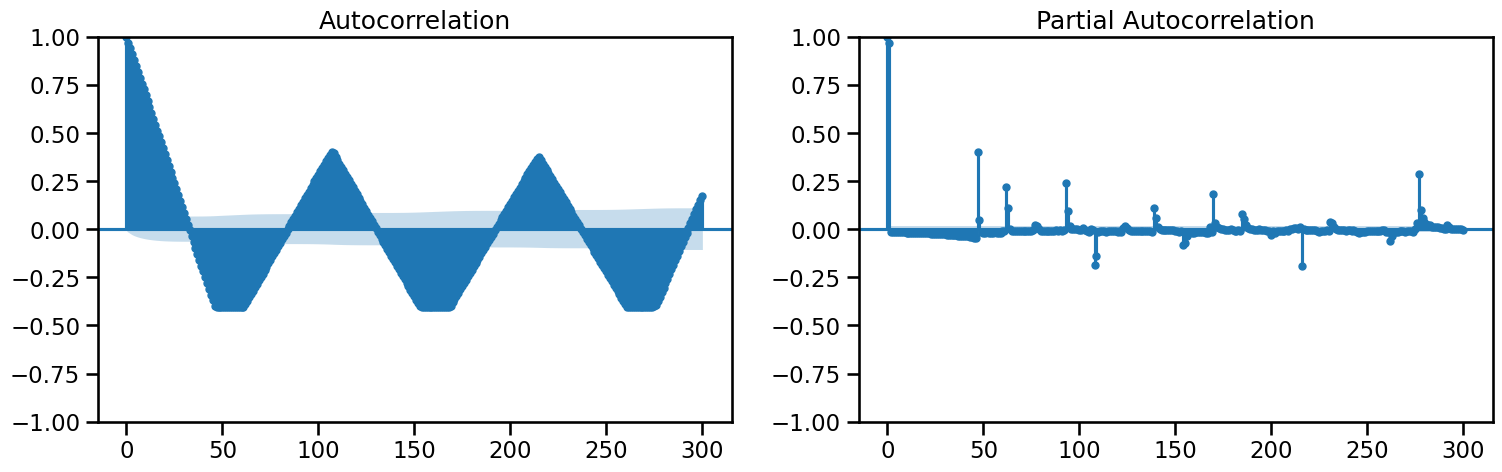

In [ ]:
plot_acf_pacf(y_cmd, 300)

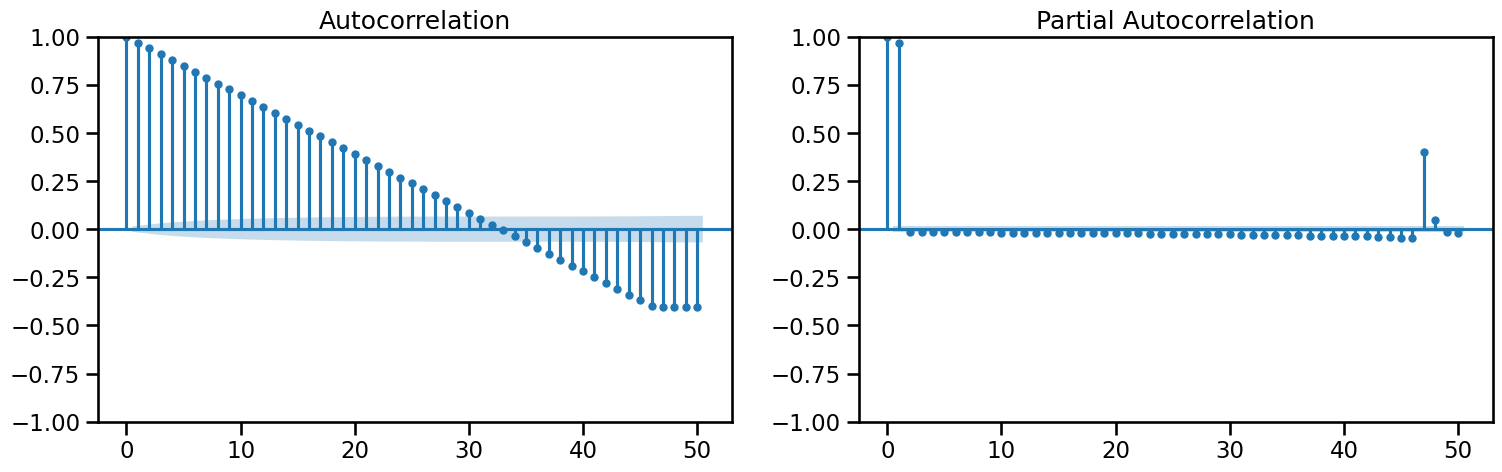

In [ ]:
plot_acf_pacf(y_cmd, 50)

Вывод: использовать сдвиг более чем на 46 лагов не имеет смысла, т.к. модель будет обманывать сама себя

## Предобработка данных

## Удаление признаков с нулевым значением

In [ ]:
def reset_zero_features(data):
    """
    Функция для удаления признаков с нулевым значением
    Args:
        df (ndarray): датасет в формате numpy

    Returns:
        df (ndarray): датасет с удалёнными признаками с нулевым значением
    """
    idx = np.argwhere(np.all(data[..., :] == 0, axis=0))
    data = np.delete(data, idx, axis=1)
    return data

In [ ]:
g = gestures[OMG_CH].values
# f. shape

In [ ]:
# g = reset_zero_features(f)
# col_list = list(gestures.columns)
g.shape

(19566, 50)

## Добавление признака с экспоненциально взвешенными скользящими средними

In [ ]:
def add_ewm_feature(df, span=10):
    """
    Функция для добавления столбцов с экспоненциально взвешенными скользящими средними (ewm)
    для каждого признака в ndarray формата numpy.

    Args:
        df (ndarray): Исходный массив данных в формате numpy
        span (int): Параметр span для расчета ewm (по умолчанию 10)

    Returns:
        ndarray: Массив данных с добавленными столбцами 'ewm' для каждого признака
    """
    df_temp = df.copy()
    col_count = df_temp.shape[1]
    new_cols = []
    for i in range(col_count):
        new_col = df_temp[:, i].cumsum() / (np.arange(df_temp.shape[0]) + 1)
        df_temp = np.column_stack((df_temp, new_col))
        new_cols.append(new_col)

    df_temp = np.delete(df_temp, range(col_count), axis=1)  # удаление исходных признаков

    return df_temp

In [ ]:
gestures_add_ewm = add_ewm_feature(g)
gestures_add_ewm.shape

(19566, 50)

## Добавление суммы изменений признака за последние несколько временных шагов.

In [ ]:
def add_weight_sum(arr, size=5, win_type='triang'):
    """
    Функция для добавления признака скользящей суммы с весами значений для массива данных в формате numpy.

    Args:
        arr (ndarray): Исходный массив данных в формате numpy
        size (int): Размер окна для скользящей суммы (по умолчанию 5)
        win_type (str): Тип оконной функции для вычисления весов (по умолчанию 'triang')

    Returns:
        ndarray: Массив данных с добавленным признаком скользящей суммы с весами значений
    """
    arr_temp = arr.copy()
    col_count = arr_temp.shape[1]
    new_cols = [] #сохраним преобразованные столбцы в отдельный список
    for i in range(col_count):
        new_col = np.convolve(arr_temp[:, i], np.ones(size)/size, mode='same')
        arr_temp = np.column_stack((arr_temp, new_col))
        new_cols.append(new_col)
    arr_temp = np.delete(arr_temp, range(col_count), axis=1)  # удаление преобразованных признаков
    return arr_temp

В этой функции я использовал функцию np.convolve из библиотеки NumPy для вычисления скользящей суммы с весами значений. Результатом функции является новый массив данных, где каждый столбец исходного массива расширен новым столбцом, содержащим признак скользящей суммы с весами значений для соответствующего столбца исходного массива

In [ ]:
gestures_weight_sum = add_weight_sum(g, size = 5, win_type = 'triang')
gestures_weight_sum.shape

(19566, 50)

## Добавление лагов

In [ ]:
def add_lag(df, step=2, lag_n=3):
    """
    Функция для добавления временных лагов в выборку с шагом
        Args:
        df (ndarray): выборка в формате numpy
        lag_n(int): количество временных лагов
        step(int): шаг сдвига по признакам

    Returns:
        df_temp(ndarray): датасет с добавленными временными лагами, пропуски заполнены 0
    """

    df_temp = df.copy()  # создаем новый датасет для добавления новых признаков
    n_samples, n_features = df_temp.shape
    col_indices = list(range(0, n_features, step))  # список индексов признаков с шагом

    for col_idx in col_indices:
        col = df_temp[:, col_idx]  # выбираем признак с шагом

        for v in range(1, lag_n):
            lag_col = np.roll(col, v) if v <= col_idx else np.zeros(n_samples)  # сдвигаем признак
            df_temp = np.column_stack((df_temp, lag_col))  # добавляем новый признак

    df_temp = np.delete(df_temp, col_indices, axis=1)  # удаляем исходные признаки

    return df_temp

In [ ]:
gestures_add_lag = add_lag(g, 2, 3) #выполняем функцию сдвига признаков с лагом
# gestures_add_lag.shape

In [ ]:
df_prepros = np.concatenate([g, gestures_add_ewm, gestures_weight_sum, gestures_add_lag], axis=1)
# df_prepros = np.concatenate([g, gestures_add_ewm, gestures_weight_sum], axis=1)
df_prepros.shape

(19566, 225)

# Train-test split

In [ ]:
# df_meta = pd.read_csv('/home/user/Рабочий стол/Моторика/motorika-internship-team/data/meta_information.csv', index_col=0)
df_meta = pd.read_csv('./meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [ ]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15676

## Шкалирование

In [ ]:
# подготовим тренировочные данные к обучению модели
# df_prepros = MinMaxScaler().fit_transform(df_prepros) #для НаивногоБайеса
df_prepros = StandardScaler().fit_transform(df_prepros)

In [ ]:
len_test = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['len(test)']

In [ ]:
X_train = df_prepros[:(last_train_idx - len_test)]
y_train = target_df[:(last_train_idx - len_test)].to_numpy()

X_valid = df_prepros[(last_train_idx - len_test):last_train_idx]
y_valid = target_df[(last_train_idx - len_test):last_train_idx].to_numpy()

X_test = df_prepros[last_train_idx:]
y_test = target_df[last_train_idx:].to_numpy()

print(X_train.shape, y_train.shape)
# print(df_prepros[:last_train_idx-len_test].min(), df_prepros[:last_train_idx-len_test].max())
print(X_valid.shape,  y_valid.shape)
# print(df_prepros[(last_train_idx - len_test):last_train_idx].min(), df_prepros[(last_train_idx - len_test):last_train_idx].max())
print(X_test.shape,  y_test.shape)
# print(df_prepros[last_train_idx:].min(), df_prepros[last_train_idx:].max())

(11784, 225) (11784, 1)
(3892, 225) (3892, 1)
(3890, 225) (3890, 1)


# Modeling

# Создадим модель решения задачи классификации

In [ ]:
# определим балансы классов для лучшего предсказания менее представленных в выборке классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.ravel(y_train))
class_weights = dict(zip(classes, weights))

# Подбор гиперпараметров

In [ ]:
# # создадим модель
# # eval_pool = Pool(X_valid, y_valid)
# model = CatBoostClassifier(
#     # iterations=300, depth=7, learning_rate=0.1,
#     loss_function='MultiClass',
#     # eval_set = (X_valid, y_valid),
#     # early_stopping_rounds = 1000,
#     verbose=False,
#     class_weights=class_weights,
#     task_type="GPU")

In [ ]:
def objective(params, model,  X, y):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """

    # задаём модели требуемые параметры
    model.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # tscv = TimeSeriesSplit(n_splits=3, test_size=len_test)

    # проводим кросс-валидацию
    score = cross_val_score(estimator=model, X=X, y=y,
                            scoring="f1_weighted", cv=skf, n_jobs=-1)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [ ]:
search_space = {'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
                'iterations': hp.randint('iterations',100,400),
                'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
                'depth': hp.randint('depth',4,7),
                'bootstrap_type' : hp.choice('bootstrap_type', ['Bayesian', 'Bernoulli'])}

In [ ]:
# trials = Trials()
# best = fmin(
#           # функция для оптимизации
#             fn=partial(objective, model=model, X = X_valid, y=y_valid),
#           # пространство поиска гиперпараметров
#             space=search_space,
#           # алгоритм поиска
#             algo=tpe.suggest,
#           # число итераций (можно ещё указать  время поиска)
#             max_evals=20,
#           # куда сохранять историю поиска
#             trials=trials,
#           # random state
#             rstate=np.random.default_rng(42),
#           # progressbar
#             show_progressbar=True
#         )

In [ ]:
# print("Наилучшие значения гиперпараметров {}".format(best))

In [ ]:
best = {'bootstrap_type': 0, 'depth': 6, 'iterations': 282, 'l2_leaf_reg': 2, 'learning_rate': 0.4124351334655566}

# Логистическая регрессия

In [ ]:
# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression(max_iter = 1000, solver = 'saga', class_weight = class_weights, random_state = 42)
# y_train = y_train.ravel()
# model.fit(
#     X=X_train,
#     y=y_train
# )

# Наивный Байес

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB()
# model.fit(X=X_train, y=y_train)

# Метод ближайших соседей(KNN)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=3, n_jobs = -1, algorithm = 'ball_tree', weights = 'uniform')
# y_train = y_train.ravel()
# model.fit(X=X_train, y=y_train)

# Метод опорных векторов(SVC)

In [ ]:
from sklearn import svm
model = svm.SVC(kernel='rbf', gamma='scale', C=1000, break_ties=True, decision_function_shape='ovr', max_iter = -1)
y_train = y_train.ravel()
model.fit(
    X=X_train,
    y=y_train
)

SVC(C=1000, break_ties=True)

# Предсказание Thumb

In [ ]:
# подготовим целевой признак
target_thumb = target_df[0].apply(lambda x: 1 if x == 3 else 0)

In [ ]:
target_thumb.value_counts()

0    18200
1     1366
Name: 0, dtype: int64

In [ ]:
y_train_thumb = target_thumb[:(last_train_idx - len_test)].to_numpy()
y_valid_thumb = target_thumb[(last_train_idx - len_test):last_train_idx].to_numpy()
y_test_thumb = target_thumb[last_train_idx:].to_numpy()

In [ ]:
from sklearn import svm

# определим балансы классов для лучшего предсказания менее представленных в выборке классов
classes = np.unique(y_train_thumb)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=np.ravel(target_thumb))
class_weights = dict(zip(classes, weights))

model_thumb = svm.SVC(kernel='rbf', gamma='auto', C=0.1, break_ties=False, class_weight = class_weights, decision_function_shape='ovo', max_iter = -1)
# model = svm.SVC(max_iter = -1)
y_train_thumb = y_train_thumb.ravel()

model_thumb.fit(
    X=X_train,
    y=y_train_thumb,
)

y_pred_train_thumb = model_thumb.predict(X_train)
y_pred_valid_thumb = model_thumb.predict(X_valid)
y_pred_test_thunb = model_thumb.predict(X_test)

In [ ]:
# определим метрики
report = classification_report(y_train_thumb, y_pred_train_thumb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92     10967
           1       0.34      0.99      0.51       817

    accuracy                           0.87     11784
   macro avg       0.67      0.92      0.71     11784
weighted avg       0.95      0.87      0.89     11784



In [ ]:
# определим метрики
report = classification_report(y_valid_thumb, y_pred_valid_thumb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      3616
           1       0.28      0.86      0.42       276

    accuracy                           0.83      3892
   macro avg       0.63      0.84      0.66      3892
weighted avg       0.94      0.83      0.87      3892



In [ ]:
report = classification_report(y_test_thumb, y_pred_test_thunb)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93      3617
           1       0.35      0.85      0.49       273

    accuracy                           0.88      3890
   macro avg       0.67      0.87      0.71      3890
weighted avg       0.94      0.88      0.90      3890



## Нейронная сеть

In [ ]:
# import tensorflow as tf
# import tensorflow

# from tensorflow import keras

# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Embedding

# num_classes = 6
# sequence_length = 11784
# input_dim = 225
# num_epochs = 10
# batch_size = 30

# # Создание модели
# model = Sequential()

# # Добавление первого слоя LSTM
# model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, input_dim)))

# # Добавление второго слоя LSTM
# model.add(LSTM(units=64))

# # Добавление выходного слоя
# model.add(Dense(units=num_classes, activation='softmax'))

# # Компиляция модели
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Обучение модели
# # model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=num_epochs, batch_size=batch_size)
# model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

# # Оценка модели на тестовых данных
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Loss: {loss}, Accuracy: {accuracy}')

## Обучим модель на найденных гиперпараметрах

In [ ]:
# model = CatBoostClassifier(depth=best['depth'],
#                            iterations=best['iterations'],
#                            learning_rate = best['learning_rate'],
#                            l2_leaf_reg = best['l2_leaf_reg'],
#                            bootstrap_type = 'Bayesian',
#                            verbose=False,
#                            random_seed=RS,
#                            loss_function='MultiClass',
#                            class_weights=class_weights,
#                            task_type="GPU")
# model.fit(X = X_train, y = y_train)

In [ ]:
# tscv = TimeSeriesSplit(n_splits=3, test_size=len_test, max_train_size=None)
# train_test_groups = tscv.split(gestures)
# for train_index, test_index in train_test_groups:
#   print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

In [ ]:
# all_splits = list(tscv.split(X, y))
# train_0, test_0 = all_splits[0]

In [ ]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# cv_results = cross_validate(
#     model,
#     X_test,
#     y_test,
#     cv=skf,
#     scoring=('f1_weighted')
#     # return_estimator=model_prop is not None,
# )
# print(cv_results['test_score'])

## Prediction

In [ ]:
# сделаем предсказание на обучающей выборке
y_pred_h = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

## Metrics

In [ ]:
# определим метрики
report = classification_report(y_train, y_pred_h)
print("Classification Report:\n", report)

# определим метрики
# f1 = f1_score(y_train, y_pred_h, average='micro')
# print("mean f_score:\n", f1)

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7681
         1.0       1.00      1.00      1.00       828
         2.0       1.00      1.00      1.00       787
         3.0       1.00      1.00      1.00       817
         4.0       1.00      1.00      1.00       839
         5.0       1.00      1.00      1.00       832

    accuracy                           1.00     11784
   macro avg       1.00      1.00      1.00     11784
weighted avg       1.00      1.00      1.00     11784



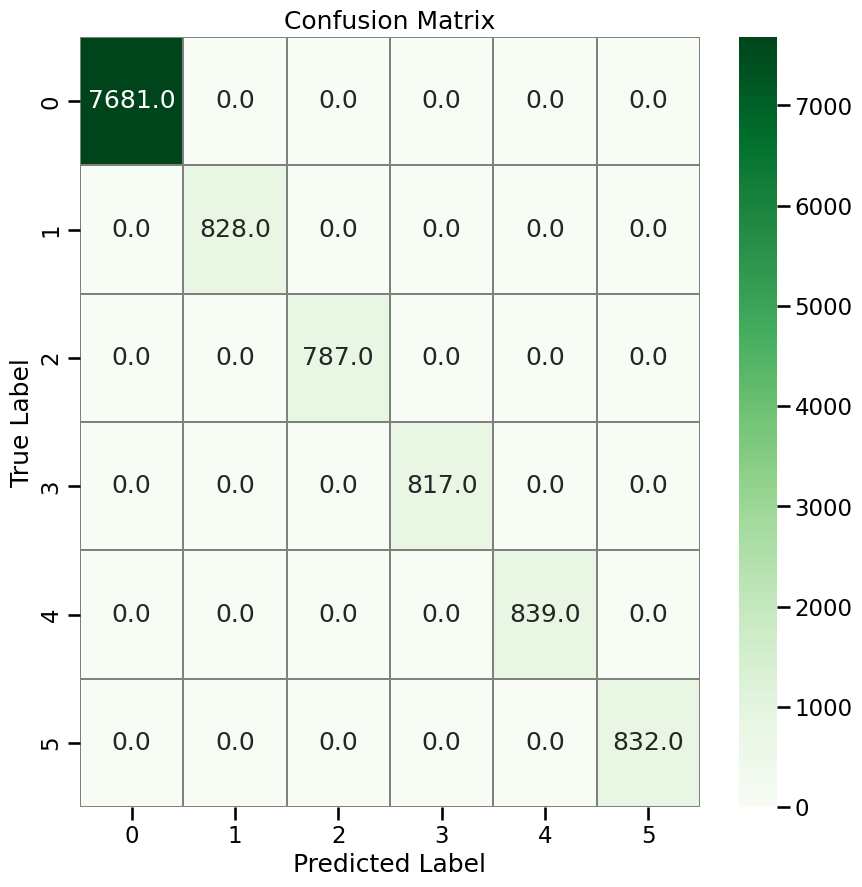

In [ ]:
#confusion matrix
confusion_mtx = confusion_matrix(y_train, y_pred_h)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Valid

              precision    recall  f1-score   support

     Neutral       0.87      0.96      0.91      2487
        Open       0.90      0.83      0.86       276
      Pistol       0.82      0.85      0.83       301
       Thumb       0.83      0.58      0.68       276
          OK       0.94      0.49      0.65       276
        Grab       0.94      0.84      0.89       276

    accuracy                           0.87      3892
   macro avg       0.88      0.76      0.81      3892
weighted avg       0.88      0.87      0.87      3892



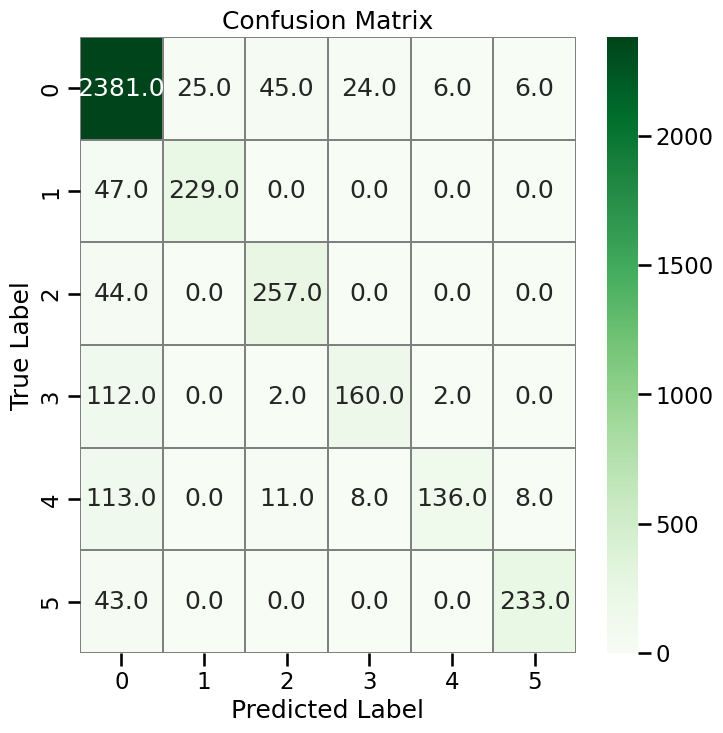

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred_valid, target_names=GESTURES))
#confusion matrix
confusion_mtx = confusion_matrix(y_valid, y_pred_valid)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

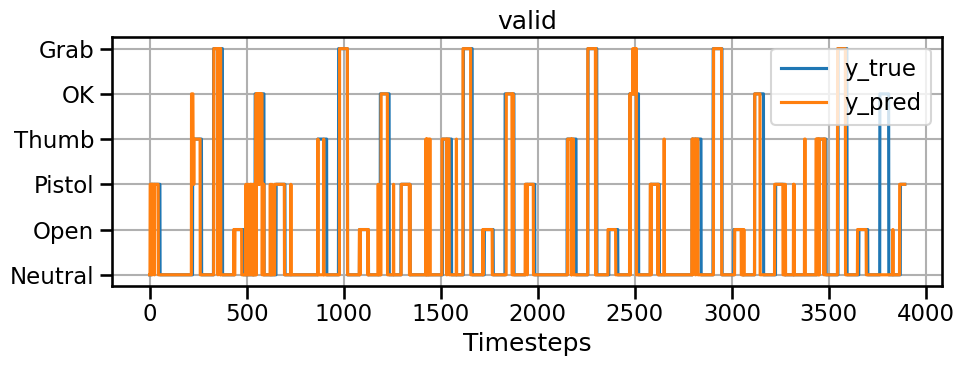

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_valid,  c='C0', label='y_true')
plt.plot(y_pred_valid, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('valid')
plt.tight_layout()

### Test

              precision    recall  f1-score   support

     Neutral       0.87      0.95      0.91      2488
        Open       0.89      0.67      0.76       276
      Pistol       0.92      0.88      0.90       300
       Thumb       0.93      0.42      0.58       273
          OK       0.76      0.78      0.77       276
        Grab       0.93      0.93      0.93       277

    accuracy                           0.87      3890
   macro avg       0.88      0.77      0.81      3890
weighted avg       0.88      0.87      0.87      3890



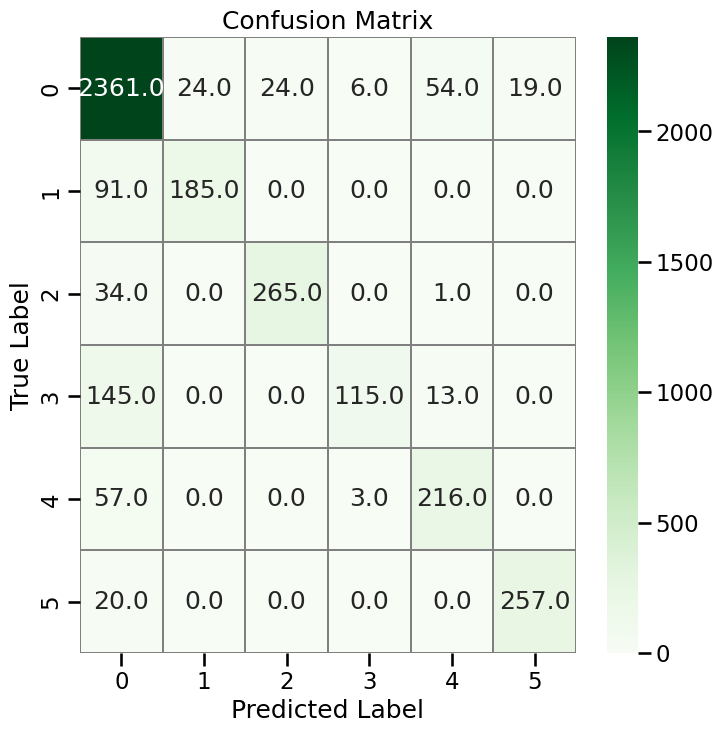

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

#confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_test)

#plot of the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

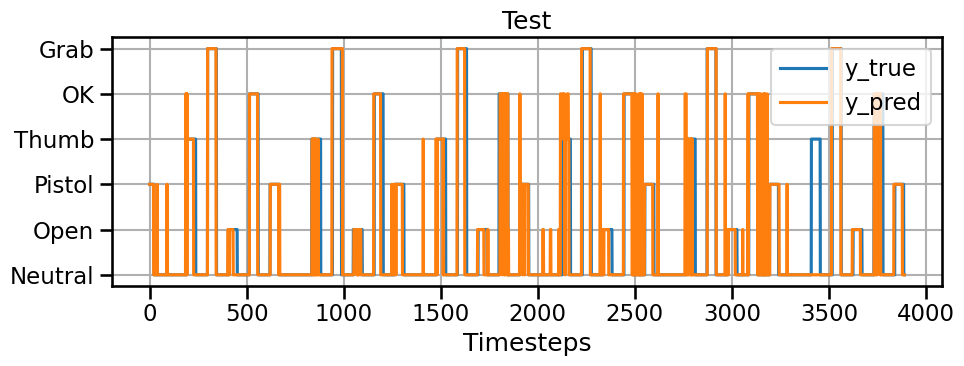

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

# Real-time inference

In [ ]:
import time
import serial
from IPython.display import clear_output

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];

def get_crc(data, count):
    """Функция рассчитывает контрольную сумму (CRC) для заданных данных.

      Args:
          data (_type_): данные, для которых нужно вычислить контрольную сумму
          count (int)       : количество байтов данных

      Returns:
          int: программа возвращает вычисленное значение контрольной суммы
    """
    result = 0x00 #Создаем переменную result и ей присваиваем начальное значение 0x00 (в шестнадцатеричном формате).
    l = count #Создаем переменную l и ей присваиваем значение переменной count.
    while (count>0): # Запускаем цикл while, который выполняется, пока значение переменной count больше 0
        result = crc_table[result ^ data[l-count]] #Обновляется значение переменной result,
        # применяя операцию XOR(исключающее ИЛИ) между текущим значением result и элементом данных data[l-count],
        # а затем используя полученное значение в качестве индекса для обращения к таблице CRC (crc_table)
        # и присваивания нового значения переменной result.
        count -= 1; #Значение переменной count уменьшается на 1 перед следующей итерацией цикла
    return result;

def drv_abs_one(ser, control):
    """ Функция принимает серийный порт и контрольную последовательность,
    формирует пакет данных с контрольной суммой и записывает его в серийный порт.

      Args:
          ser  (_type_):серийный порт
          control (): контрольная последовательность

      Returns:
          _type_: Записанный в серийный порт пакет данных с контрольной последовательностью
    """
    if ser is None: #Если серийный порт ser равен None, то функция завершается.
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    #Создается переменная pack, которая содержит массив байтов.
    #Массив состоит из чисел 80, 0x01, 0xBB, 6 и элементов массива control.
    #В конце массива добавляется 0.
    pack[-1] = get_crc(pack[1:], 9)
    #Последний элемент массива pack обновляется с помощью функции get_crc.
    #Для этого передается срез массива pack с индекса 1 до конца и число 9 в качестве параметров.
    #Возвращенное значение устанавливается в последний элемент массива pack.
    return (pack, ser.write(bytearray(pack)))
    #Значение pack и результат вызова функции ser.write(bytearray(pack)) возвращаются в виде кортежа.
    #Вызов bytearray(pack) преобразует массив pack в байтовую строку,
    #а затем эта строка записывается в серийный порт ser с помощью метода write.

## Inference Utils: Put your code here

In [ ]:
def preprocessing(data, n_lags):
  if len(data) < n_lags:
    # print(0)
    return np.zeros(225)
  else:
    data_n = np.array(data)
    # Добавление признака с экспоненциально взвешенными скользящими средними
    data_add_ewm = add_ewm_feature(data_n)
    # Добавление суммы изменений признака за последние несколько временных шагов.
    data_weight_sum = add_weight_sum(data_n, size = 5, win_type = 'triang')
    # Добавление лагов
    data_add_lag = add_lag(data_n, step = 2, lag_n = 3) #выполняем функцию сдвига признаков с лагом
    # объединение преобразований
    df = np.concatenate([data_n, data_add_ewm, data_weight_sum, data_add_lag], axis=1)
    return df[-1]

def inference(x):
    f = np.array(x)
    # f.reshape(1, 1)
    # print(f.shape)
    y_thumb = model_thumb.predict(f)
    y = model.predict(f)
    y_pred = y[-1]
    y_pred_thumb = y_thumb[-1]
    if y_pred_thumb == 1:
      return 3
    else:
      return y_pred

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

Следующий этап это цикл, который читает данные, предобрабатывает их, производит прогнозы, выполняет постобработку прогнозов и составляет команды.

In [ ]:
df_temp = gestures.iloc[last_train_idx:]
df_columns = gestures.columns
# df = MinMaxScaler().fit_transform(df_temp) #для НаивногоБайеса
df = StandardScaler().fit_transform(df_temp)
df_sim = pd.DataFrame(df, columns = df_columns)
print(df_sim.shape)

(3890, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;
ts_diff_list = []
n_lags = 10

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    # print(omg_sample.shape)
    sample_preprocessed  = preprocessing(y_dct['omg_sample'][-n_lags:], n_lags)
    # [/Data preprocessing]
    y_dct['sample_preprocessed'].append(sample_preprocessed)

    # [Inference]
    y_predicted        = inference(y_dct['sample_preprocessed'][-n_lags:])
    # y_predicted         = inference(sample_preprocessed)

    # print(y_predicted.shape)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    # y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    # print(i)
    # print(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # print(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # print(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)

    ts_diff = time.time() - ts_start
    ts_diff_list.append(ts_diff)
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1
print(round(np.array(ts_diff_list).max(),3))

0.253


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3890, 50)
enc_sample.shape = (3890, 6)
sample_preprocessed.shape = (3890, 225)
y_predicted.shape = (3890,)
y_postprocessed.shape = (3890,)
y_commands.shape = (3890,)


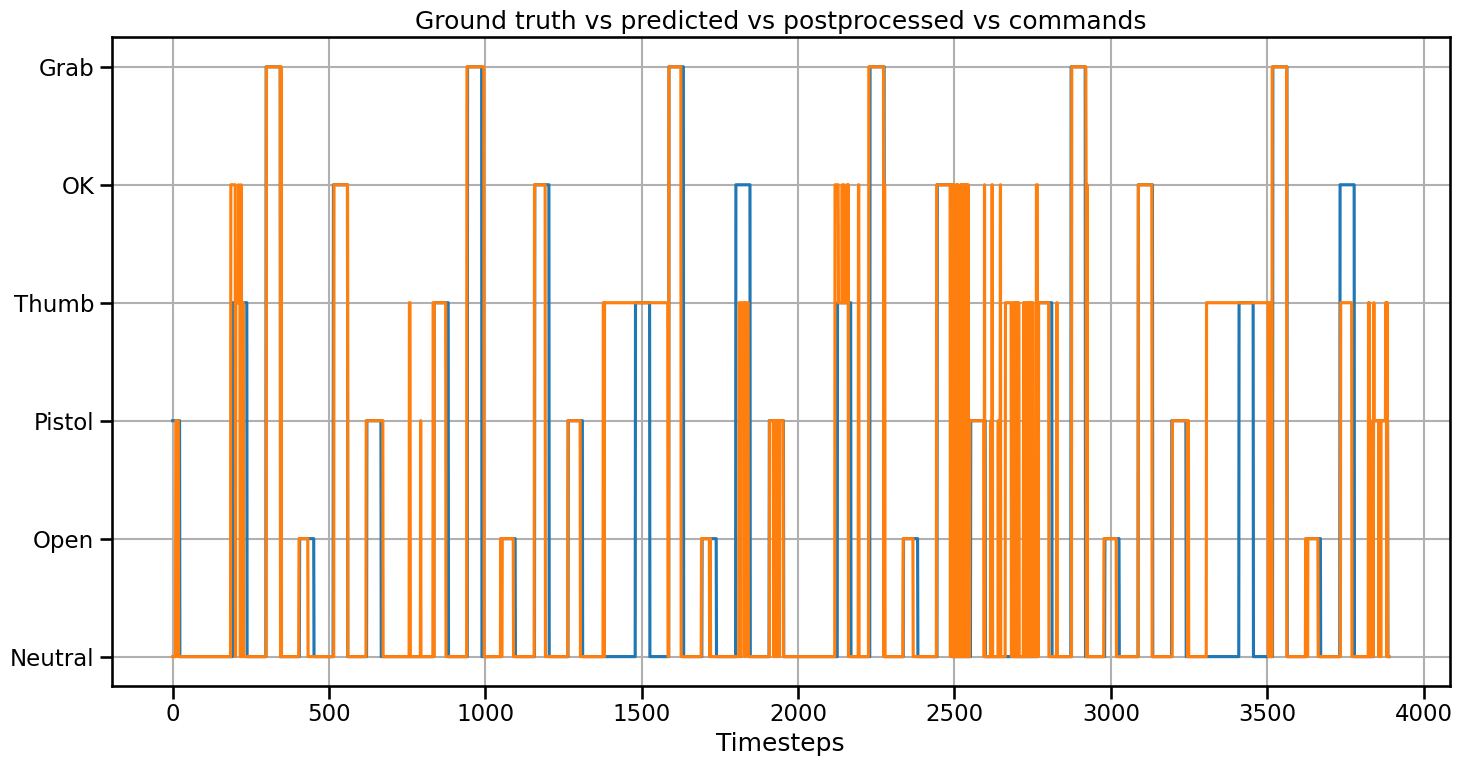

In [ ]:
fig = plt.figure(figsize=(15, 8))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
# plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
# plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
# plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_predicted'], target_names=GESTURES))
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.90      0.81      0.85      2488
        Open       0.95      0.70      0.80       276
      Pistol       0.91      0.85      0.88       300
       Thumb       0.32      0.76      0.45       273
          OK       0.69      0.61      0.64       276
        Grab       0.94      0.95      0.94       277

    accuracy                           0.79      3890
   macro avg       0.78      0.78      0.76      3890
weighted avg       0.85      0.79      0.81      3890

              precision    recall  f1-score   support

     Neutral       0.93      0.67      0.78      2488
        Open       0.30      0.73      0.43       276
      Pistol       0.39      0.63      0.48       300
       Thumb       0.32      0.72      0.44       273
          OK       0.53      0.35      0.42       276
        Grab       0.94      0.56      0.70       277

    accuracy                           0.64      3890
   macro avg       0.57

### Online (prosthesis or virtual hand)

In [ ]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# # ser_port = None
# # ser_port = '/dev/ttyACM0'
# ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()

#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()

# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:

#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()

#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

#     except Exception as e:
#         print(e)

#     # [/Data Reading]

#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]

#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]

#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]

#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]

#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]

#     y_previous = y_postprocessed

#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)

#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1